In [150]:
# Load data and packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"

df = pd.read_csv(directory_path)


In [151]:
# Data cleaning
print("Number of rows is: " + str(df.shape[0]))

df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])

print("Number of rows cleaned data is: " + str(df.shape[0]))

Number of rows is: 8949721
Number of rows cleaned data is: 7450939


In [152]:
# Data preparation
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.day_of_week + 1
df['week'] = df['scanning_date'].dt.day_of_year // 7 + 1
df['yearday'] = df['scanning_date'].dt.day_of_year
df['yearday_sin'] = np.sin(df['yearday'] / 7 * 2 * np.pi)
df['yearday_cos'] = np.cos(df['yearday'] / 7 * 2 * np.pi)

sorting_center_names = df["sorting_center_name"].unique()
df["sorting_center_name"].value_counts()

VANTAA       4888466
TAMPERE      1154436
KUOPIO        578274
LIETO         443087
OULU          354047
SEINÄJOKI      32629
Name: sorting_center_name, dtype: int64

In [153]:
#aggregating data
adf = df.groupby(['scanning_date','sorting_center_name'])['no_of_events'].sum().reset_index()
adf['day'] = adf['scanning_date'].dt.day
adf['month'] = adf['scanning_date'].dt.month
adf['weekday'] = adf['scanning_date'].dt.day_of_week + 1
adf['week'] = adf['scanning_date'].dt.day_of_year // 7 + 1
adf['yearday'] = adf['scanning_date'].dt.day_of_year
adf['yearday_sin'] = np.sin(adf['yearday'] / 7 * 2 * np.pi)
adf['yearday_cos'] = np.cos(adf['yearday'] / 7 * 2 * np.pi)
adf

,scanning_date,sorting_center_name,no_of_events,day,month,weekday,week,yearday,yearday_sin,yearday_cos
0,2023-01-01,LIETO,3650,1,1,7,1,1,7.818315e-01,0.623490
1,2023-01-01,OULU,1441,1,1,7,1,1,7.818315e-01,0.623490
2,2023-01-01,TAMPERE,1458,1,1,7,1,1,7.818315e-01,0.623490
3,2023-01-02,KUOPIO,23812,2,1,1,1,2,9.749279e-01,-0.222521
4,2023-01-02,LIETO,44598,2,1,1,1,2,9.749279e-01,-0.222521
...,...,...,...,...,...,...,...,...,...,...
1876,2023-12-29,OULU,19831,29,12,5,52,363,-7.818315e-01,0.623490
1877,2023-12-29,SEINÄJOKI,15100,29,12,5,52,363,-7.818315e-01,0.623490
1878,2023-12-29,TAMPERE,34499,29,12,5,52,363,-7.818315e-01,0.623490
1879,2023-12-29,VANTAA,129349,29,12,5,52,363,-7.818315e-01,0.623490


In [154]:
#missing dates: 9 april, 24 june, 24 dec, 25 dec, 31 dec

In [155]:
#import plotly.express as px
#fig_weekday = px.histogram(df.weekday,x='weekday')
#fig_weekday.update_layout(bargap=0.2)
#fig_weekday.show()

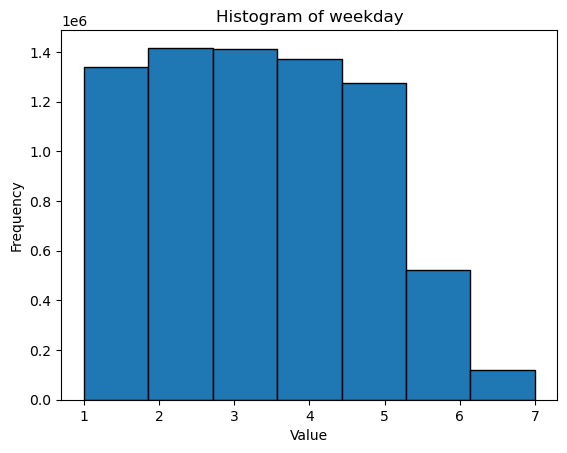

In [156]:
# Create the histogram
plt.hist(df['weekday'], bins=7, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of weekday')

# Show the plot
plt.show()

              no_of_events
no_of_events      1.000000
day               0.021900
month             0.050323
weekday          -0.289534
week              0.049091
yearday           0.052139
yearday_sin      -0.100394
yearday_cos      -0.240350


C:\Users\krist\AppData\Local\Temp\ipykernel_18696\4022224248.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  target_covariance_matrix = adf.corr()[['no_of_events']]


<Axes: >

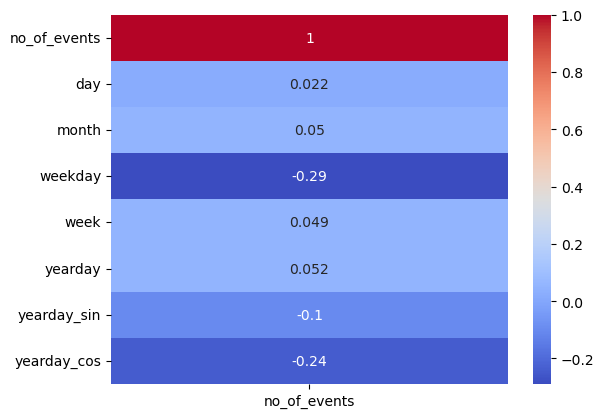

In [157]:
import seaborn as sns
#determine correlations
target_covariance_matrix = adf.corr()[['no_of_events']]
print(target_covariance_matrix)
sns.heatmap(target_covariance_matrix,annot=True, cmap='coolwarm')

In [158]:
X = adf[['week','day','weekday']]
y = adf['no_of_events']

In [159]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [160]:
#print coefficient values for unstandardized model
print(model.coef_)
print(model.intercept_)

[  183.35184434    51.27938877 -7192.42932543]
64133.30543567074


In [161]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X)
# Calculate metrics
r_squared = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

# Print the metrics
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.0873
Mean Absolute Error: 31185.0597
Mean Squared Error: 2071221522.4148
Root Mean Squared Error: 45510.6748


In [162]:
#standardize the values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()

# Fit the model to the standardized data
model.fit(X_scaled, y)


LinearRegression()

In [163]:
#coefficients of the standardized multiple regression model
print(['week','day','weekday'])
print(model.coef_)

['week', 'day', 'weekday']
[  2763.27309343    449.08249896 -13868.7931668 ]


In [205]:


# Create lag features (e.g., lag 1, lag 2)
def create_lag_features(series, lags):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags+1):
        lagged_data[f'lag_{lag}'] = series.shift(lag)
    return lagged_data

# Create a copy of the DataFrame for the features
X = pd.DataFrame(index=vantaa.index).copy()  # Ensure it's a copy
X.loc[:, 'lag_1'] = vantaa['no_of_events'].shift(1)
X.loc[:, 'lag_3'] = vantaa['no_of_events'].shift(3)
X.loc[:, 'lag_4'] = vantaa['no_of_events'].shift(4)
X.loc[:, 'lag_5'] = vantaa['no_of_events'].shift(5)
X.loc[:, 'lag_6'] = vantaa['no_of_events'].shift(6)
X.loc[:, 'lag_7'] = vantaa['no_of_events'].shift(7)
# Create day_of_week feature
X['day_of_week'] = vantaa['scanning_date'].dt.day_of_week + 1

# Create cyclic features for day_of_week
X['cos_day_of_week'] = np.cos(2 * np.pi * X['day_of_week'] / 7)
X['sin_day_of_week'] = np.sin(2 * np.pi * X['day_of_week'] / 7)

# Drop NaN values after creating lag features
X.dropna(inplace=True)

print(X)
y = vantaa['no_of_events'][7:]  # Target variable is the actual series shifted by the number of lags
dates = vantaa['scanning_date'][7:]  # Corresponding dates for the target
features = ['lag_1','lag_3','lag_4', 'lag_5', 'lag_6', 'lag_7', 'day_of_week', 'cos_day_of_week', 'sin_day_of_week'] 

# Split the data into train and test sets
X_train, X_rest, y_train, y_rest, dates_train, dates_rest = train_test_split(
    X, y, dates, test_size=0.25, shuffle=False
)
X_test, X_drop, y_test, y_drop, dates_test, dates_drop = train_test_split(
    X_rest, y_rest, dates_rest, test_size=0.8, shuffle=False
)

# Train the model
model = LinearRegression()
model.fit(X_train[features], y_train)

test_data = X_test.copy()  # Make a copy of the test data
predictions = []

# Recursive forecasting loop
for i in range(len(X_test)):
    # Select the current row of features (including lags)
    row_data = X_test[features].iloc[i].to_frame().T  # Keep it as a DataFrame with feature names
    
    # Make the prediction for the current step
    pred = model.predict(row_data)[0]
    
    # Append the prediction to the predictions list
    predictions.append(pred)
    
    # Now, update lag_1 with this prediction for the next step
    if i + 1 < len(X_test):
        X_test.loc[X_test.index[i + 1], 'lag_1'] = pred  # Update lag_1 for the next day
        

# Convert predictions list to a NumPy array or DataFrame for analysis
predictions = np.array(predictions)

# Evaluate the model with the test set (ground truth vs predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse}")

         lag_1     lag_3     lag_4     lag_5     lag_6     lag_7  day_of_week  \
40        31.0   18913.0  144020.0  160294.0  154829.0  140723.0            1   
46    160507.0   51989.0   18913.0  144020.0  160294.0  154829.0            2   
52    201353.0      31.0   51989.0   18913.0  144020.0  160294.0            3   
58    192287.0  160507.0      31.0   51989.0   18913.0  144020.0            4   
64    173355.0  201353.0  160507.0      31.0   51989.0   18913.0            5   
...        ...       ...       ...       ...       ...       ...          ...   
1861   21677.0  177114.0  224659.0  256965.0  226832.0   48786.0            2   
1867     119.0  117771.0  177114.0  224659.0  256965.0  226832.0            3   
1873  144831.0   21677.0  117771.0  177114.0  224659.0  256965.0            4   
1879  152030.0     119.0   21677.0  117771.0  177114.0  224659.0            5   
1880  129349.0  144831.0     119.0   21677.0  117771.0  177114.0            6   

      cos_day_of_week  sin_

In [206]:

X_test

,lag_1,lag_3,lag_4,lag_5,lag_6,lag_7,day_of_week,cos_day_of_week,sin_day_of_week
1429,161049.000000,172836.0,159316.0,2.0,55552.0,140013.0,5,-0.222521,-9.749279e-01
1431,129490.699002,168357.0,172836.0,159316.0,2.0,55552.0,6,0.623490,-7.818315e-01
1437,47674.354308,161049.0,168357.0,172836.0,159316.0,2.0,7,1.000000,-2.449294e-16
1443,-2307.537844,153489.0,161049.0,168357.0,172836.0,159316.0,1,0.623490,7.818315e-01
1449,143343.912716,51631.0,153489.0,161049.0,168357.0,172836.0,2,-0.222521,9.749279e-01
1455,160900.124504,56.0,51631.0,153489.0,161049.0,168357.0,3,-0.900969,4.338837e-01
1461,151750.953472,162995.0,56.0,51631.0,153489.0,161049.0,4,-0.900969,-4.338837e-01
1467,151530.430641,169558.0,162995.0,56.0,51631.0,153489.0,5,-0.222521,-9.749279e-01
1468,126676.355501,159927.0,169558.0,162995.0,56.0,51631.0,6,0.623490,-7.818315e-01
1473,46157.303499,166261.0,159927.0,169558.0,162995.0,56.0,7,1.000000,-2.449294e-16


In [207]:
predictions

array([129490.69900211,  47674.3543084 ,  -2307.53784374, 143343.91271593,
       160900.12450437, 151750.95347242, 151530.43064128, 126676.35550098,
        46157.30349933,  -1971.14443831, 144656.76875773, 159466.17801385,
       152195.44647182, 150722.77364695, 127298.03005849,  46465.58213424])

In [208]:
y_test

1429    153489
1431     51631
1437        56
1443    162995
1449    169558
1455    159927
1461    166261
1467    153226
1468     56994
1473        14
1479    165420
1485    185995
1491    162325
1497    149263
1503    145319
1504     57446
Name: no_of_events, dtype: int64

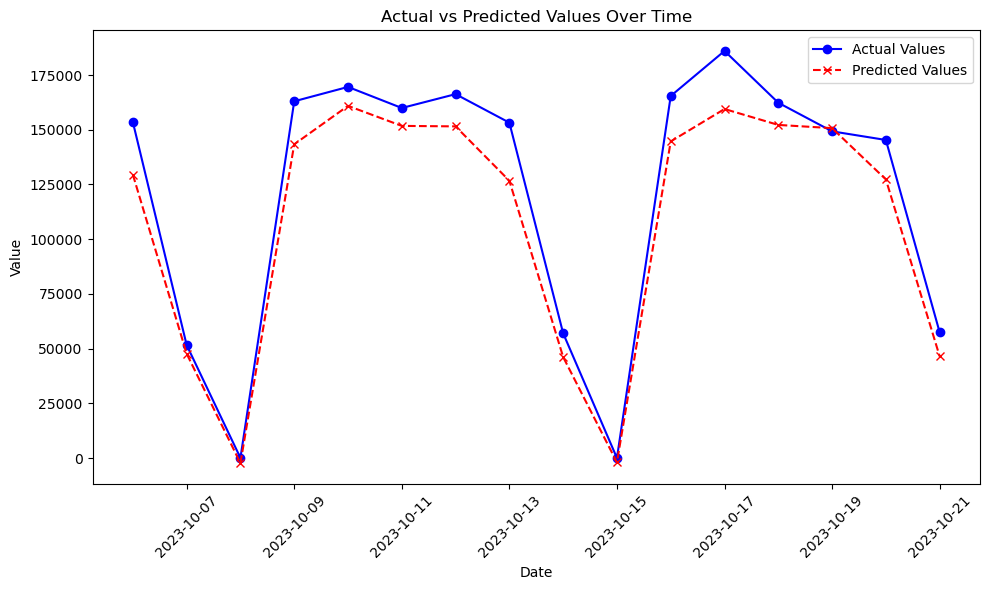

In [202]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(dates_test, y_test, label='Actual Values', color='blue', marker='o')

# Plot predicted values
plt.plot(dates_test, predictions, label='Predicted Values', color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values Over Time')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [22]:
df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index = False)['no_of_events'].sum()

In [124]:
#calculate per chute
def lingres(center,belt):
    chute = df[(df['sorting_center_name'] == center) & (df['output_belt'] == belt)]
    lags = 2  # You can change the number of lags
    X = create_lag_features(chute['no_of_events'], lags)
    X.dropna(inplace=True)
    y = chute['no_of_events'][lags:]  # Target variable is the actual series shifted by the number of lags
    dates = chute['scanning_date'][lags:]  # Corresponding dates for the target

    # Split the data into train and test sets
    X_train, X_rest, y_train, y_rest, dates_train, dates_rest = train_test_split(
        X, y, dates, test_size=0.25, shuffle=False
    )
    X_test, X_drop, y_test, y_drop, dates_test, dates_drop = train_test_split(
        X_rest, y_rest, dates_rest, test_size=0.8, shuffle=False
    )

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    rmse_per_day = []
    for i in range(1,len(dates_test)):
        rmse_per_day.append(np.round(np.sqrt(mean_squared_error(np.array(y_test)[:i],y_pred[:i])),2)) 
    return rmse, mae , rmse_per_day
lingres('VANTAA', 91)

(464.45265506897306,
 428.37894055245465,
 [442.11,
  489.8,
  530.29,
  571.02,
  564.52,
  521.33,
  492.65,
  529.17,
  506.27,
  506.28,
  511.82,
  505.72,
  487.37,
  474.29])

In [125]:
sorting_centers = df['sorting_center_name'].unique()

for c in range(len(sorting_centers)):
    belts = df[(df['sorting_center_name'] == sorting_centers[c])]['output_belt'].unique()
    rmse_avg = []
    mae_avg = []
    for b in range(len(belts)):
        rmse_avg.append(lingres(sorting_centers[c],belts[b])[0])
        mae_avg.append(lingres(sorting_centers[c],belts[b])[1])
    print('The average rmse for sorting center ' + sorting_centers[c] + ' is '+ str(np.average(rmse_avg)))
    print('The average mae for sorting center ' + sorting_centers[c] + ' is '+ str(np.average(mae_avg)))

The average rmse for sorting center KUOPIO is 54.440570751707604
The average mae for sorting center KUOPIO is 39.92033703590762
The average rmse for sorting center LIETO is 113.07900735340162
The average mae for sorting center LIETO is 89.51815923826976
The average rmse for sorting center OULU is 85.56416187680705
The average mae for sorting center OULU is 72.30007683728599
The average rmse for sorting center SEINÄJOKI is 133.36481500477964
The average mae for sorting center SEINÄJOKI is 98.67266352942235
The average rmse for sorting center TAMPERE is 105.0813545622348
The average mae for sorting center TAMPERE is 81.09063528373798
The average rmse for sorting center VANTAA is 338.7157892202026
The average mae for sorting center VANTAA is 286.82935258990096


The next step would be to add more features to see if it improves the benchmarks.

In [127]:
def lingres_features(center,belt):
    chute = df[(df['sorting_center_name'] == center) & (df['output_belt'] == belt)]
    lags = 7  # You can change the number of lags
    X = create_lag_features(chute['no_of_events'], lags)
    X['day_of_week'] = df['scanning_date'].dt.day_of_week + 1
    X['cos_day_of_week'] = np.cos(2 * np.pi * X['day_of_week'] / 7)
    X['sin_day_of_week'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
    X['weeklag2'] = chute['no_of_events'].shift(14)
    #print(X)
    X.dropna(inplace=True)
    y = chute['no_of_events'][14:]  # Target variable is the actual series shifted by the number of lags
    dates = chute['scanning_date'][14:]  # Corresponding dates for the target

    # Split the data into train and test sets
    X_train, X_rest, y_train, y_rest, dates_train, dates_rest = train_test_split(
        X, y, dates, test_size=0.25, shuffle=False
    )
    X_test, X_drop, y_test, y_drop, dates_test, dates_drop = train_test_split(
        X_rest, y_rest, dates_rest, test_size=0.8, shuffle=False
    )

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    rmse_per_day = []
    for i in range(1,len(dates_test)):
        rmse_per_day.append(np.round(np.sqrt(mean_squared_error(np.array(y_test)[:i],y_pred[:i])),2)) 
    return rmse, mae , rmse_per_day
lingres_features('VANTAA', 91)

(162.71817356790498,
 131.75251538122768,
 [81.86,
  84.12,
  73.87,
  65.58,
  200.3,
  193.28,
  182.0,
  174.98,
  179.71,
  175.25,
  172.59,
  176.05,
  172.78,
  166.8])

In [128]:
sorting_centers = df['sorting_center_name'].unique()

for c in range(len(sorting_centers)):
    belts = df[(df['sorting_center_name'] == sorting_centers[c])]['output_belt'].unique()
    rmse_avg = []
    mae_avg = []
    for b in range(len(belts)):
        rmse_avg.append(lingres_features(sorting_centers[c],belts[b])[0])
        mae_avg.append(lingres_features(sorting_centers[c],belts[b])[1])
    print('The average rmse for sorting center ' + sorting_centers[c] + ' is '+ str(np.average(rmse_avg)))
    print('The average mae for sorting center ' + sorting_centers[c] + ' is '+ str(np.average(mae_avg)))

The average rmse for sorting center KUOPIO is 33.18412486728776
The average mae for sorting center KUOPIO is 26.527466265531178
The average rmse for sorting center LIETO is 49.244913587280045
The average mae for sorting center LIETO is 38.990486332600206
The average rmse for sorting center OULU is 33.60010674882181
The average mae for sorting center OULU is 26.213496938362997
The average rmse for sorting center SEINÄJOKI is 70.98579006237061
The average mae for sorting center SEINÄJOKI is 56.85040505266346
The average rmse for sorting center TAMPERE is 31.33563112875571
The average mae for sorting center TAMPERE is 24.89228072539044
The average rmse for sorting center VANTAA is 148.59433321436754
The average mae for sorting center VANTAA is 119.01038432882342


Adding day of the week improves the results for all sorting centers.
Then adding the cosine slightly improves, but not for Lieto.
Best results by adding weekday, sine and cosine.
Then investigate the number of lags. Adding more generally improves - until around 6 day-lags.
Adding a two-week lag also slightly improves. Three-week does not.

In [ ]:
T